In [19]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
import pickle
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
import lightfm.evaluation as lv
import optuna
import scipy.stats as ss
import matplotlib.pyplot as pl

In [5]:
train_joke_df = pd.read_csv(r'../data/recsys-in-practice/train_joke_df.csv')

In [6]:
train_joke_df["UID"] = train_joke_df["UID"].astype(int)
train_joke_df["JID"] = train_joke_df["JID"].astype(int)

train_joke_df['UID'] = train_joke_df['UID'] - 1
train_joke_df['JID'] = train_joke_df['JID'] - 1

In [7]:
train_joke_df

,UID,JID,Rating
0,18028,5,-1.26
1,3297,63,-4.17
2,3365,57,0.92
3,12734,91,3.69
4,11364,37,-6.60
...,...,...,...
1448359,22603,25,2.82
1448360,22254,35,-1.94
1448361,21055,39,-9.56
1448362,12327,96,0.87


In [8]:
train_df, valid_df = train_test_split(train_joke_df, test_size=0.5, random_state=42)

len(valid_df)

724182

In [9]:
train_df["UID"] = train_df["UID"].astype(int)
train_df["JID"] = train_df["JID"].astype(int)
valid_df["UID"] = valid_df["UID"].astype(int)
valid_df["JID"] = valid_df["JID"].astype(int)


# сделаем сортировку и перепишем index
train_df = train_df.sort_values(by=['UID', 'JID'])
train_df = train_df.reset_index(drop=True)

valid_df = valid_df.sort_values(by=['UID', 'JID'])
valid_df = valid_df.reset_index(drop=True)

In [10]:
lfm_dataset = LFMDataset()
lfm_dataset.fit(users=train_df["UID"].values, items=train_df["JID"].values)

train_interactions, _ = lfm_dataset.build_interactions(zip(*train_df[["UID", "JID"]].values.T))
test_interactions, _ = lfm_dataset.build_interactions(zip(*valid_df[["UID", "JID"]].values.T))

In [25]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
        
        if np.mean(precision_at) > 0.664:
            break
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2023-05-12 15:46:47,529] A new study created in memory with name: no-name-e55ebde0-04d8-40cd-b8e7-4d7aaa0f2ddb
[I 2023-05-12 15:46:49,632] Trial 0 finished with value: 0.6629908084869385 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.001, 'max_sampled': 100, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.6629908084869385.
[I 2023-05-12 15:46:51,572] Trial 1 finished with value: 0.6630948781967163 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 1 with value: 0.6630948781967163.
[I 2023-05-12 15:46:53,892] Trial 2 finished with value: 0.6578633785247803 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.0001, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.6630948781967163.
[I 2023-05-12 15:46:56,211] Trial 3 finished with value: 0.6627826690673828 and parameters: {'lo

In [15]:
best_params

{'loss': 'warp',
 'no_components': 30,
 'learning_rate': 0.001,
 'max_sampled': 50,
 'user_alpha': 0.0,
 'item_alpha': 0.0}

In [26]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.662234365940094 +/- 0.0018522639598221502
1:	0.6627786755561829 +/- 0.0018550197619355783
2:	0.6626986265182495 +/- 0.0018542082101800346
3:	0.6628026366233826 +/- 0.0018536666213377082
4:	0.6630068421363831 +/- 0.0018522521339313593
5:	0.6630549430847168 +/- 0.0018543922506054722
6:	0.6633350253105164 +/- 0.001852856917377601
7:	0.6633350253105164 +/- 0.001849631775223399
8:	0.6634031534194946 +/- 0.0018486572479103898
9:	0.663483202457428 +/- 0.0018485012939755813
10:	0.6634190678596497 +/- 0.0018508021688526366
11:	0.6635592579841614 +/- 0.0018499800846631072
12:	0.6635311841964722 +/- 0.0018537342506506703
13:	0.6635391712188721 +/- 0.0018501024087209785
14:	0.6637433171272278 +/- 0.0018489724818117916
15:	0.6636111736297607 +/- 0.001848023823634888
16:	0.6637953519821167 +/- 0.0018463476883947847
17:	0.6636873483657837 +/- 0.0018453374986298584
18:	0.6634351015090942 +/- 0.0018477889688349575
19:	0.6635192632675171 +/- 0.0018471950873817887
20:	0.6634231805801392 +/- 0.001845

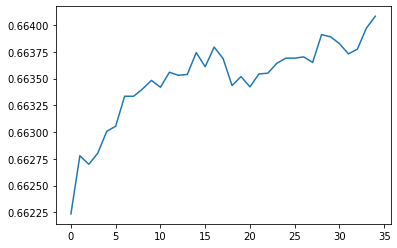

In [27]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

In [28]:
with open('models/lightfm05.pkl', 'wb') as f:
    pickle.dump(model, f)

In [29]:
with open('models/lightfm05_dataset.pkl', 'wb') as f:
    pickle.dump(lfm_dataset, f)